In [4]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
from time import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F
from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [5]:
a = 1

In [6]:
_NOISE_DIM = 8
_H_FILTERS = 4

In [7]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [8]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)

In [9]:
def detach_tuple(Tuple):
    return (x.detach_() for x in Tuple)

In [10]:
# correct lola
device = args["device"]
iterations = args["iterations"]
batch_size = args["batch_size"]
dataset = load_mnist(_data_root='datasets', binarized=False)
n_workers = 4
eta_lookahead = 1
lr = 0.0001
sampler = get_sampler(
    dataset, batch_size, shuffle=True, num_workers=n_workers, drop_last=True
)
lbl_real = torch.ones(batch_size, 1, device=device)
lbl_fake = torch.zeros(batch_size, 1, device=device)

G.to(device)
D.to(device)

for i in range(iterations):
    if i ==0:
        start = time()
    x_real, _ = sampler()
    x_real = x_real.to(device)

    # loss D
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    x_gen = G(z)
    lossD = get_disciminator_loss(D, x_real, x_gen, lbl_real, lbl_fake)

    # loss G
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    lossG = get_generator_loss(G, D, z, lbl_real)

    # Calculating the SGD terms
    gradsD = torch.autograd.grad(lossD, D.parameters(), create_graph=True)
    gradsG = torch.autograd.grad(lossG, G.parameters(), create_graph=True)

    # Calculating the JVP
    dLD_dG = torch.autograd.grad(lossD, G.parameters(), create_graph=True)
    dLG_dD = torch.autograd.grad(lossG, D.parameters(), create_graph=True)
    J_D_P_dLG_dD = torch.autograd.grad(gradsD, G.parameters(), grad_outputs = dLG_dD)
    J_G_P_dLD_dG = torch.autograd.grad(gradsG, D.parameters(), grad_outputs = dLD_dG)

    # Calculating the LookAhead Step
    gradsD_LookAhead = detach_tuple(gradsD+J_G_P_dLD_dG * eta_lookahead)
    gradsG_LookAhead = detach_tuple(gradsG+J_D_P_dLG_dD * eta_lookahead)

    # Updating the Networks
    for param, grad in zip(D.parameters(),gradsD_LookAhead):
        param.data -= grad*lr
    for param, grad in zip(G.parameters(),gradsG_LookAhead):
        param.data -= grad*lr
    if i%1000 == 0:
        end = time()
        print("iter: ", i)
        print("lossD: ", lossD.item())
        print("lossG: ", lossG.item())
        print("time cost: ", end-start)
        start = time()

iter:  0
lossD:  1.4437634944915771
lossG:  0.6276097297668457
time cost:  0.18486309051513672
iter:  1000
lossD:  1.1064461469650269
lossG:  0.6296601295471191
time cost:  42.27976322174072


KeyboardInterrupt: 

In [11]:
# wrong lola
device = args["device"]
iterations = args["iterations"]
batch_size = args["batch_size"]
dataset = load_mnist(_data_root='datasets', binarized=False)
n_workers = 4
eta_lookahead = 1
lr = 0.0001
sampler = get_sampler(
    dataset, batch_size, shuffle=True, num_workers=n_workers, drop_last=True
)
lbl_real = torch.ones(batch_size, 1, device=device)
lbl_fake = torch.zeros(batch_size, 1, device=device)

G.to(device)
D.to(device)

for i in range(iterations):
    if i ==0:
        start = time()
    x_real, _ = sampler()
    x_real = x_real.to(device)

    # loss D
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    x_gen = G(z)
    lossD = get_disciminator_loss(D, x_real, x_gen, lbl_real, lbl_fake)

    # loss G
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    lossG = get_generator_loss(G, D, z, lbl_real)

    # Calculating the SGD terms
    gradsD = torch.autograd.grad(lossD, D.parameters(), create_graph=True)
    gradsG = torch.autograd.grad(lossG, G.parameters(), create_graph=True)

    # Calculating the JVP
    dLD_dG = torch.autograd.grad(lossD, G.parameters(), create_graph=True)
    dLG_dD = torch.autograd.grad(lossG, D.parameters(), create_graph=True)
    J_D_P_dLG_dD = torch.autograd.grad(gradsD, G.parameters(), grad_outputs = dLG_dD)
    J_G_P_grad_D = torch.autograd.grad(gradsG, D.parameters(), grad_outputs = dLD_dG)

    # Calculating the LookAhead Step
    gradsD_LookAhead = detach_tuple(gradsD+J_D_P_dLG_dD * eta_lookahead)
    gradsG_LookAhead = detach_tuple(gradsG+J_G_P_grad_D * eta_lookahead)

    # Updating the Networks
    for param, grad in zip(D.parameters(),gradsD_LookAhead):
        param.data -= grad*lr
    for param, grad in zip(G.parameters(),gradsG_LookAhead):
        param.data -= grad*lr
    if i%1000 == 0:
        end = time()
        print("iter: ", i)
        print("lossD: ", lossD.item())
        print("lossG: ", lossG.item())
        print("time cost: ", end-start)
        start = time()

iter:  0
lossD:  1.0804047584533691
lossG:  0.67572021484375
time cost:  0.06939530372619629
iter:  1000
lossD:  1.283009648323059
lossG:  0.62162184715271
time cost:  41.301108598709106


KeyboardInterrupt: 

In [17]:
gradsG[0].shape

torch.Size([8, 32, 3, 3])

In [15]:
J_D_P_dLG_dD[0].shape

torch.Size([8, 32, 3, 3])

In [80]:
device = args["device"]
iterations = args["iterations"]
batch_size = args["batch_size"]
dataset = load_mnist(_data_root='datasets', binarized=False)
n_workers = 4
eta_lookahead = 1
lr = 0.0001
sampler = get_sampler(
    dataset, batch_size, shuffle=True, num_workers=n_workers, drop_last=True
)
lbl_real = torch.ones(batch_size, 1, device=device)
lbl_fake = torch.zeros(batch_size, 1, device=device)

G.to(device)
D.to(device)

for i in range(iterations):
    if i ==0:
        start = time()
    x_real, _ = sampler()
    x_real = x_real.to(device)

    # loss D
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    x_gen = G(z)
    lossD = get_disciminator_loss(D, x_real, x_gen, lbl_real, lbl_fake)

    # loss G
    z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
    lossG = get_generator_loss(G, D, z, lbl_real)

    # Calculating the SGD terms
    gradsD = torch.autograd.grad(lossD, D.parameters(), create_graph=True)
    gradsG = torch.autograd.grad(lossG, G.parameters(), create_graph=True)

    # Calculating the JVP
    dLD_dG = torch.autograd.grad(lossD, G.parameters(), create_graph=True)
    dLG_dD = torch.autograd.grad(lossG, D.parameters(), create_graph=True)
    J_D_P_grad_G = torch.autograd.grad(dLD_dG, D.parameters(), grad_outputs = gradsG)
    J_G_P_grad_D = torch.autograd.grad(dLG_dD, G.parameters(), grad_outputs = gradsD)

    # Calculating the LookAhead Step
    gradsD_LookAhead = detach_tuple(gradsD+J_D_P_grad_G * eta_lookahead)
    gradsG_LookAhead = detach_tuple(gradsG+J_G_P_grad_D * eta_lookahead)

    # Updating the Networks
    for param, grad in zip(D.parameters(),gradsD_LookAhead):
        param.data -= grad*lr
    for param, grad in zip(G.parameters(),gradsG_LookAhead):
        param.data -= grad*lr
    if i%1000 == 0:
        end = time()
        print("iter: ", i)
        print("lossD: ", lossD.item())
        print("lossG: ", lossG.item())
        print("time cost: ", end-start)
        start = time()

iter:  0
lossD:  1.3404502868652344
lossG:  0.7881301641464233
time cost:  0.045519113540649414
iter:  1000
lossD:  1.2351443767547607
lossG:  0.6493948101997375
time cost:  25.780089139938354
iter:  2000
lossD:  1.1581275463104248
lossG:  0.6537896394729614
time cost:  27.07682728767395
iter:  3000
lossD:  1.0838878154754639
lossG:  0.7969905138015747
time cost:  25.37028741836548
iter:  4000
lossD:  1.1158428192138672
lossG:  0.7977834343910217
time cost:  27.26705527305603
iter:  5000
lossD:  1.2772674560546875
lossG:  0.7501564025878906
time cost:  27.002684116363525
iter:  6000
lossD:  1.0976250171661377
lossG:  0.8970158696174622
time cost:  26.98004961013794
iter:  7000
lossD:  0.973142147064209
lossG:  1.0238088369369507
time cost:  25.998576164245605
iter:  8000
lossD:  1.08255934715271
lossG:  0.8506584167480469
time cost:  26.949941873550415
iter:  9000
lossD:  0.9393980503082275
lossG:  0.9697446823120117
time cost:  26.440016269683838
iter:  10000
lossD:  0.977601647377014

KeyboardInterrupt: 

In [81]:
#eval
z = torch.randn(args["batch_size"], _NOISE_DIM, device=device)
output = G(z)

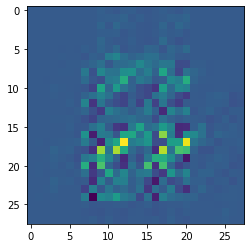

In [85]:
plt.imshow(output[0,0].cpu().detach().numpy())